<a href="https://colab.research.google.com/github/EdgarData/Edgar-Portfolio/blob/main/Time_Series_Energy_priceprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resumen Ejectivo 💼


- Hemos hecho una comparativa entre varios modelos de predicción, en este caso para la predicción del precio medio diario de la energía, trabajando con data en formato fecha. A contunuación Os mostramos el grado de error que tiene cada uno de los medelos.
- Creemos que la mejor opcón para este caso es un modelo sencillo que pueda tomar en cuenta diferentes parámetros y sea flexible a la hora de predecir. En este caso Modelo Arima
- En los siguientes pasos os mostraemos algunos gráficos con las predicciones mas acertadas, donde podremos visualizar de una mejor manera la información.

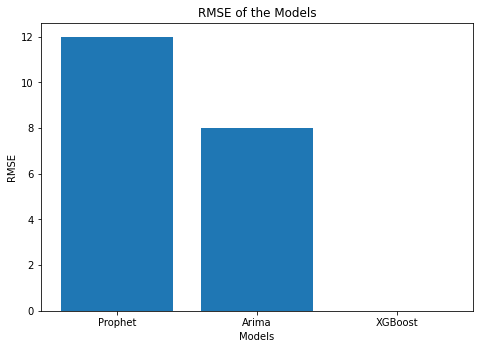

In [ ]:
# Haremos una gráfica para comparar los modelos
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
modelz = ['Prophet', "Arima", 'XGBoost']
nums = [12,8,0,]
ax.bar(modelz,nums)
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('RMSE of the Models')
plt.show()
plt.show()

# Informe de Negocio 📊



*   Aqui podemos apreciar la prediccion de uno de nuestros modelos. Que en resumen nos viene a decir que se estima un precio por debajo de los 60$ para el 2021.




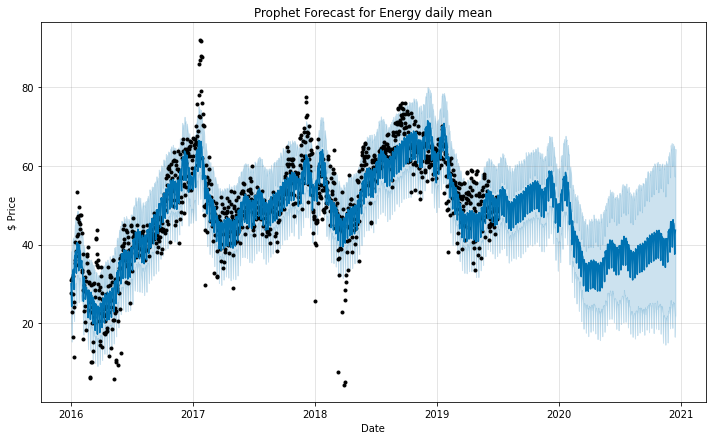

Este es modelo que hemos seleccionado para esta predicción del precio medio diario durante el siguiente año. Es un modelo mas flexible donde podemos ir mejorando según los hyperparámetros que introduscamos. La idea es mejorar los 3 parámetros (Autoregressive (p) Integrated (d) Moving Average (q)) del modelo haciendo varias pruebas. También lo hemos elegido por que tiene una menor tasa de error sonre la prediccion que hemos hecho.

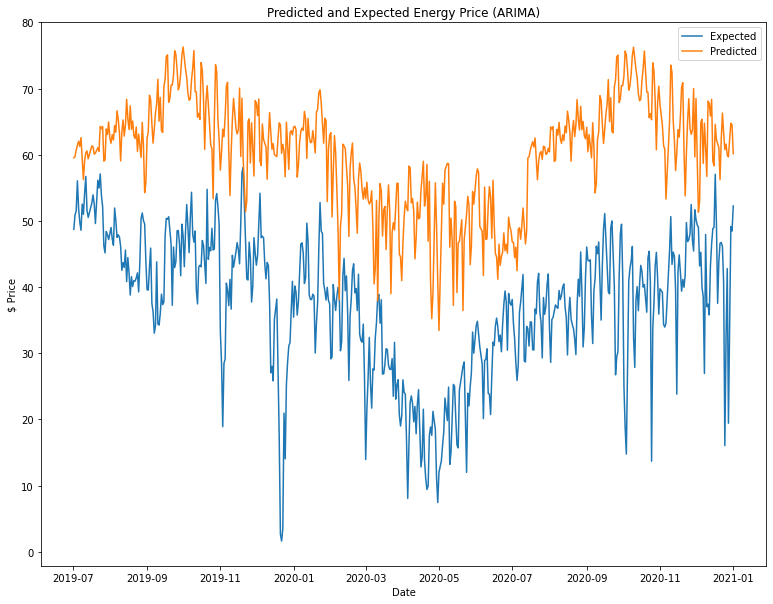

# Reporte Científico 👩🏻‍💻

1000 palabras máx <br>
Incluye todo el código de cierta relevancia.<br>
Tiene que estar ordenado secuencialmente, pero no hace falta que siga la historia del Informe de Negocio. <br>
El resto de puede estar en apendices <br>

In [ ]:
!pip install fbprophet
!pip install statsmodels
!pip install pmdarima

In [ ]:
# Import libraries
#import warnings
# warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        # FutureWarning)
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas.plotting import autocorrelation_plot

In [ ]:
# import Data
path = "/content/df_energy_price_spain.csv"
energy = pd.read_csv(path, parse_dates = ['date'], index_col = 'date')
del energy["Unnamed: 0"]

In [ ]:
energy

,value
date,
2016-01-01 01:00:00,48.55
2016-01-01 02:00:00,40.00
2016-01-01 03:00:00,33.10
2016-01-01 04:00:00,28.11
2016-01-01 05:00:00,27.13
...,...
2020-12-31 20:00:00,60.54
2020-12-31 21:00:00,56.75
2020-12-31 22:00:00,52.44


In [ ]:
energy.dtypes

value    float64
dtype: object

In [ ]:
#para las series temporales necesitamos trabajar con series (numpy arrays) por lo que ya lo dejamos listo
series_value = energy.values
type(series_value)

numpy.ndarray

In [ ]:
# Pasamos a formato fecha "date"
energy.index = pd.to_datetime(energy.index, format="%Y-%m-%d %H:%M:%S")
energy.dtypes

value    float64
dtype: object

In [ ]:
# Resamples the data to the average daily value of each column. Removes excessive frequency
energy = energy.resample('D').mean()
# drops any missing values that are present
energy = energy.dropna()
energy.tail()

,value
date,
2020-12-28,19.434783
2020-12-29,33.980000
2020-12-30,49.140435
2020-12-31,48.467500
2021-01-01,52.260000


In [ ]:
# Veamos las proporciones
energy.describe().T

,count,mean,std,min,25%,50%,75%,max
value,1776.0,46.355311,13.707618,1.6275,38.548646,46.91375,55.69125,92.03


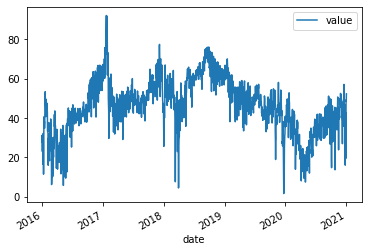

In [ ]:
energy.plot()
# Podemos observar un considerable aumento del precio de la energía en los meses mas fríos los 2 primeros años. 
# A pertir de ahi, parece que la tendencia es a la baja con HH nuevamente en en diciembre del 2021.

In [ ]:
energy_mean = energy.rolling(window=7).mean()
# Podemos observar con mayor precision si aplicamos un "zoom" en el gráfico por semana o por mes (7 ó 30)

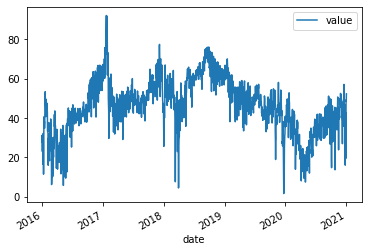

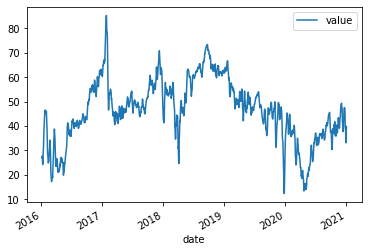

In [ ]:
energy.plot()
energy_mean.plot()

## Autocorrelación

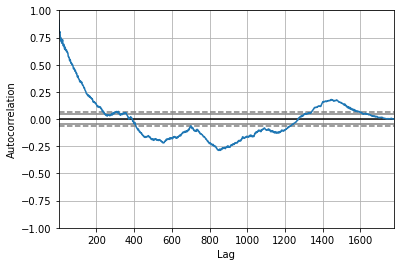

In [ ]:
# Ploteamos la autocorrelación de los valores para ver si hay un numero grande de lags en la serie temporal.
autocorrelation_plot(energy)
plt.show()

## Creamos y entrenamos el modelo Prophet

In [ ]:
# importing Prophet model
# importing prophet library
import fbprophet
from fbprophet import Prophet
# print version number
print('Prophet %s' % fbprophet.__version__)

Prophet 0.7.1


In [ ]:
# Para Prophet fitteamos el modelo convitiendo las columnas en "ds" y "y"
energy_prophet = energy.copy()
energy_prophet.reset_index(inplace=True)
energy_prophet = energy_prophet[['date', 'value']]
energy_prophet.columns = ['ds', 'y']
# A continuación dividimos la data en train y test
X = energy_prophet
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]

In [ ]:
model = Prophet()
# fit the model
model.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## Predicciones

In [ ]:
# La frecuencia es el día y el tamaño de la data el test
future = model.make_future_dataframe(periods=len(test), freq='D')
forecasting = model.predict(future)
# La predicción se guarda y nos arroja el margen de error
y_true = test['y'].values
y_pred = forecasting.yhat.values[-len(test):]
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 11.599


In [ ]:
forecasting.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1771,2020-12-11,34.082289,24.243681,64.961777,15.398002,52.322250,10.821768,10.821768,10.821768,1.452150,1.452150,1.452150,9.369617,9.369617,9.369617,0.0,0.0,0.0,44.904057
1772,2020-12-12,34.047866,21.914225,61.700933,15.321288,52.351977,7.256062,7.256062,7.256062,-1.756256,-1.756256,-1.756256,9.012319,9.012319,9.012319,0.0,0.0,0.0,41.303928
1773,2020-12-13,34.013442,16.609943,57.302236,15.245468,52.330626,3.548357,3.548357,3.548357,-5.050685,-5.050685,-5.050685,8.599042,8.599042,8.599042,0.0,0.0,0.0,37.561799
1774,2020-12-14,33.979019,21.554606,62.263974,15.169647,52.326973,8.509670,8.509670,8.509670,0.372782,0.372782,0.372782,8.136888,8.136888,8.136888,0.0,0.0,0.0,42.488689
1775,2020-12-15,33.944596,22.125044,64.284820,15.093827,52.369797,9.714706,9.714706,9.714706,2.080554,2.080554,2.080554,7.634152,7.634152,7.634152,0.0,0.0,0.0,43.659302


## Visualizacion de resultados

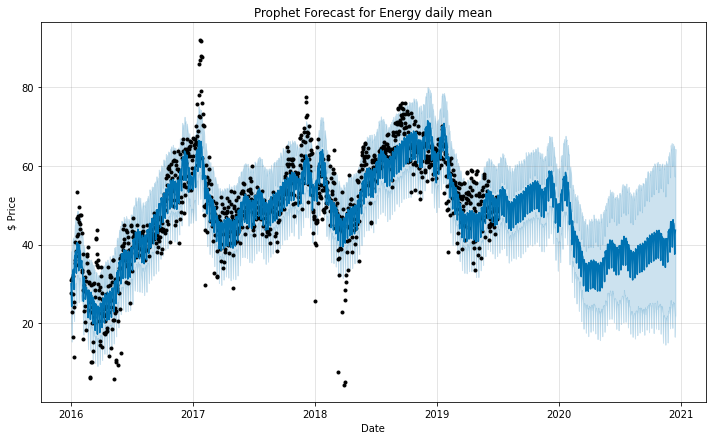

In [ ]:
# Plotting forecast
model.plot(forecasting)
plt.title('Prophet Forecast for Energy daily mean')
plt.ylabel('$ Price')
plt.xlabel('Date')
plt.show()

In [ ]:
#Como podemos observar en este gráfico, las predicciones del modelo están dentro de los datos reales y siguen el mismo momentum. Ciertamente no hay ningún pico desproporcionado ni a la alta ni a la baja
#como si lo podemos observar en los datos actuales en Enero y Diciembre del 2017 (Pico máximo de 102€), así como a la baja en Marzo del 2018 llegando a rozar los 2.30

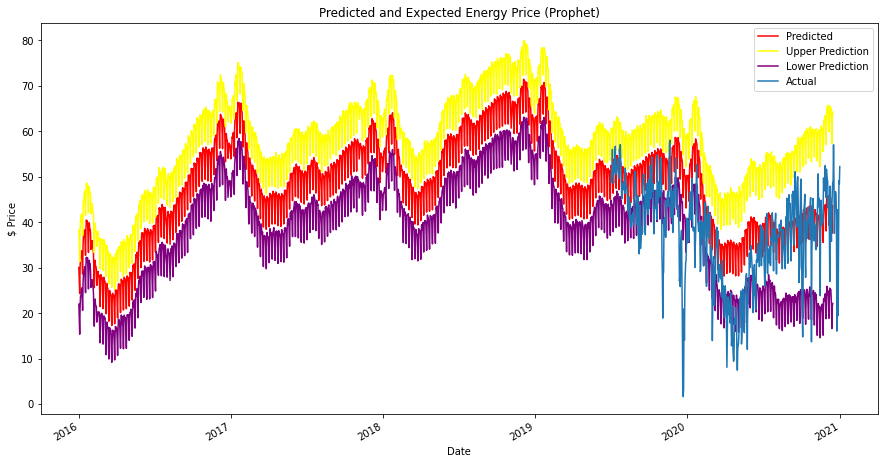

In [ ]:
# Plotting forecast con la data de test
ax = forecasting.plot(x='ds', y='yhat', legend=True, label="Predicted", figsize=(15,8), color='red')
forecasting.plot(x='ds', y='yhat_upper', legend=True, label='Upper Prediction', ax=ax, color='yellow')
forecasting.plot(x='ds', y='yhat_lower', legend=True, label='Lower Prediction', ax=ax, color='purple')
test.plot(x='ds', y='y', legend=True, label='Actual', ax=ax)
plt.ylabel('$ Price')
plt.xlabel('Date')
plt.title('Predicted and Expected Energy Price (Prophet)')
plt.legend(loc='best')
plt.show()

# Arima Model

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
# Utilizaremos este método después
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i-interval]
        diff.append(value)
    return np.array(diff)

def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [ ]:
print(len(test))

533


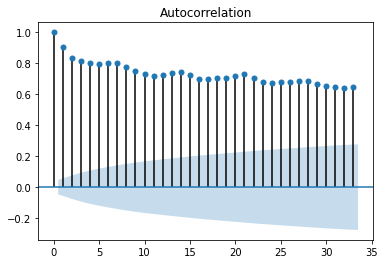

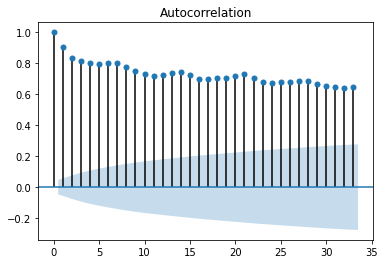

In [ ]:
# Antes de entrenar el modelo, intentemos definir los 3 parámetros de ARIMA - Autoregressive (p) Integrated (d) Moving Average (q)
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

# utilizamos plt_acf para dedinir el parametro Q. Hay mucha autocorrelacion a casi todos los niveles, provemos con un 5.

plot_acf(energy)

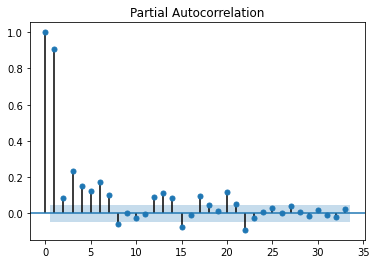

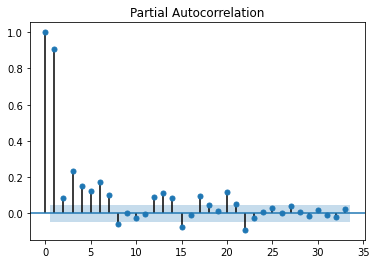

In [ ]:
plot_pacf(energy) # Lo utilizamos para identificar el valor de p. Según la gráfica utilizaremos un p valor de 2

In [ ]:
# Dividimos la data en train y test como en el método anterior 30% y 70%
price = energy.value
X = price.values
datesX = price.index
size = int(len(X) * 0.70)
train, test = X[0:size], X[size:len(X)]
days_in_year = 365
plotDates = datesX[size:len(X)]

# A continuación haremos la prediccion con ARIMA usando (p, d, q) 2,1,5
differenced = difference(train, days_in_year)
model = ARIMA(differenced, order=(2, 1, 5))
model_fit = model.fit()
start_index = len(differenced)
end_index = start_index + 532
forecast = model_fit.predict(start=start_index, end=end_index)

history = [x for x in train]
day = 1
predicted_results = list()

# Almacenamos los resultados de la predicción
for yhat in forecast:
    inverted = inverse_difference(history, yhat, days_in_year)
    print("Predicted Day %d: %f" % (day, inverted))
    history.append(inverted)
    predicted_results.append(inverted)
    day += 1

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)




Predicted Day 1: 59.537696
Predicted Day 2: 59.716898
Predicted Day 3: 60.681187
Predicted Day 4: 61.457260
Predicted Day 5: 62.052369
Predicted Day 6: 61.243198
Predicted Day 7: 62.584659
Predicted Day 8: 59.410588
Predicted Day 9: 56.238832
Predicted Day 10: 59.080961
Predicted Day 11: 60.292889
Predicted Day 12: 60.571179
Predicted Day 13: 59.385759
Predicted Day 14: 61.337291
Predicted Day 15: 61.220080
Predicted Day 16: 60.089989
Predicted Day 17: 60.236962
Predicted Day 18: 61.064689
Predicted Day 19: 60.518369
Predicted Day 20: 64.271348
Predicted Day 21: 63.926984
Predicted Day 22: 64.268794
Predicted Day 23: 59.037795
Predicted Day 24: 59.208077
Predicted Day 25: 63.893593
Predicted Day 26: 63.059440
Predicted Day 27: 64.950358
Predicted Day 28: 62.526157
Predicted Day 29: 61.746756
Predicted Day 30: 63.042746
Predicted Day 31: 62.218481
Predicted Day 32: 64.426170
Predicted Day 33: 63.395706
Predicted Day 34: 66.634343
Predicted Day 35: 65.351512
Predicted Day 36: 63.330041
P

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)




                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  877
Model:                 ARIMA(2, 1, 5)   Log Likelihood               -3044.283
Method:                       css-mle   S.D. of innovations              7.780
Date:                Fri, 10 Sep 2021   AIC                           6106.566
Time:                        14:28:33   BIC                           6149.554
Sample:                             1   HQIC                          6123.008
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0565      0.101     -0.561      0.575      -0.254       0.141
ar.L1.D.y      1.1901      0.012    102.304      0.000       1.167       1.213
ar.L2.D.y     -0.9814      0.013    -75.818      0.0

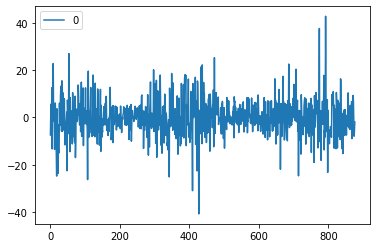

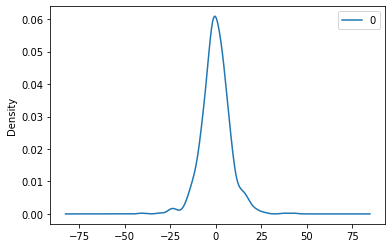

                0
count  877.000000
mean    -0.002385
std      7.791409
min    -40.792322
25%     -4.291103
50%     -0.139994
75%      4.096965
max     42.821692


In [ ]:
print(model_fit.summary())
# line plot de los residuos
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot de los residuos
residuals.plot(kind='kde')
plt.show()
# resumen estadístico de los residuos
print(residuals.describe())

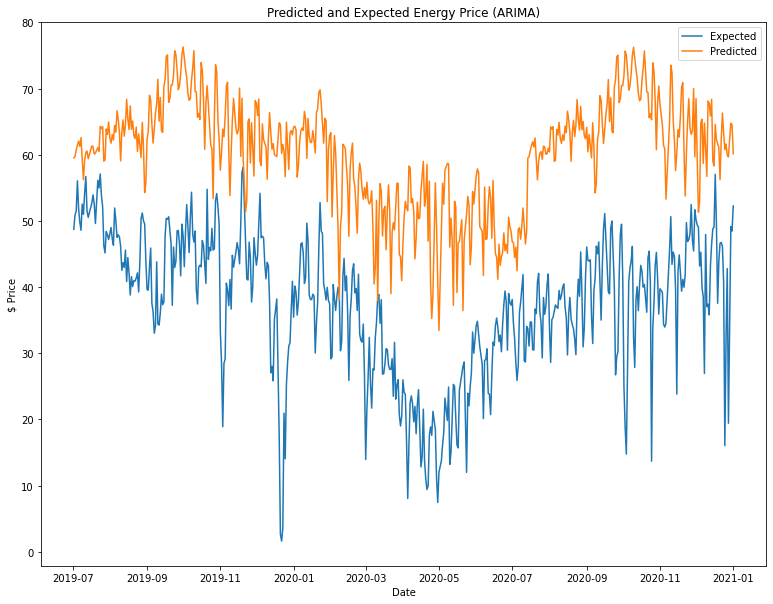

In [ ]:
plt.figure(figsize=(13,10))
plt.plot(plotDates, test, label='Expected')
plt.plot(plotDates, predicted_results, label='Predicted')
plt.ylabel('$ Price')
plt.xlabel('Date')
plt.legend(loc='best')
plt.title('Predicted and Expected Energy Price (ARIMA)')
plt.show()

## XBOOST MODEL

In [ ]:
import plotly.express as px
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from folium import plugins

In [ ]:
xboost = energy.reset_index()

In [ ]:
xboost

,date,value
0,2016-01-01,27.751304
1,2016-01-02,31.123333
2,2016-01-03,22.992917
3,2016-01-04,31.274167
4,2016-01-05,31.433333
...,...,...
1771,2020-12-28,19.434783
1772,2020-12-29,33.980000
1773,2020-12-30,49.140435
1774,2020-12-31,48.467500


In [ ]:
split_date = pd.to_datetime('2017-06-30')
xboost_train= xboost.loc[xboost.date <= split_date].copy()
xboost_test = xboost.loc[xboost.date > split_date].copy()

In [ ]:
def create_features(df, column, label=None):
    """
    Creates time series features from datetime index
    """
    xboost['date'] = xboost[[column]]
    xboost['hour'] = xboost['date'].dt.hour
    xboost['dayofweek'] = xboost['date'].dt.dayofweek
    xboost['quarter'] = xboost['date'].dt.quarter
    xboost['month'] = xboost['date'].dt.month
    xboost['year'] = xboost['date'].dt.year
    xboost['dayofyear'] = xboost['date'].dt.dayofyear
    xboost['dayofmonth'] = xboost['date'].dt.day
    xboost['weekofyear'] = xboost['date'].dt.weekofyear
    
    X = xboost[['hour','dayofweek','quarter','month',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = xboost[label]
        return X, y
    return X

In [ ]:
import datetime
X_train, y_train = create_features(xboost_train, label='value', column = 'date')
X_test, y_test = create_features(xboost_test, label='value', column = 'date')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [ ]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

[14:28:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

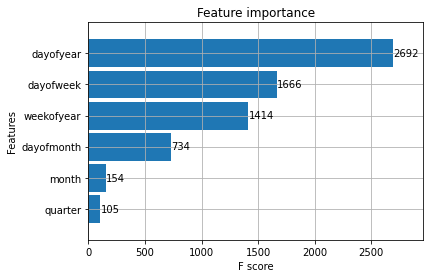

In [ ]:
_ = plot_importance(reg, height=0.9)

In [ ]:
xboost_test['Energy_Prediction'] = reg.predict(X_test)
xboost_all = pd.concat([xboost_test, xboost_train], sort=False)

ValueError: ignored

In [ ]:
xboost_test

,date,value
534,2017-07-01,44.608333
535,2017-07-02,42.470000
536,2017-07-03,47.516250
537,2017-07-04,48.999583
538,2017-07-05,48.485417
...,...,...
1771,2020-12-28,19.434783
1772,2020-12-29,33.980000
1773,2020-12-30,49.140435
1774,2020-12-31,48.467500


## Comparacion de modelos

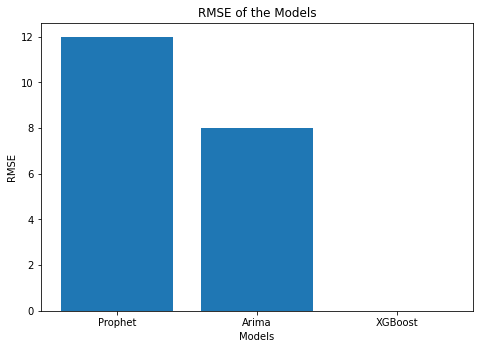

In [ ]:
# Haremos una gráfica para comparar los modelos
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
modelz = ['Prophet', "Arima", 'XGBoost']
nums = [12,8,0,]
ax.bar(modelz,nums)
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('RMSE of the Models')
plt.show()
plt.show()